In [1]:
import torch
from chapter04 import GPTModel
GPT_CONFIG_124M = {
"vocab_size": 50257,
"context_length": 256,
"emb_dim": 768,
"n_heads": 12,
"n_layers": 12,
"drop_rate": 0.1,
"qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();

In [2]:
import tiktoken
from chapter04 import generate_text_simple

def text_to_token_ids(text, tokenizer):
   encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
   encoded_tensor = torch.tensor(encoded).unsqueeze(0)
   return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
   flat = token_ids.squeeze(0)
   return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(model=model, idx=text_to_token_ids(start_context, tokenizer), max_new_tokens=10, context_size=GPT_CONFIG_124M["context_length"])
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [3]:
inputs = torch.tensor([[16833, 3626, 6100],
                       [40, 1107, 588]])

In [4]:
targets = torch.tensor([[3626, 6100, 345 ],
                        [1107, 588, 11311]])

In [5]:
with torch.no_grad():
   logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [6]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [7]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [8]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)
text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [9]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [10]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


In [11]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


In [12]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [13]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [14]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


In [15]:
file_path = "/content/the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
   text_data = file.read()

In [16]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [17]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [18]:
from chapter04 import create_dataloader_v1

torch.manual_seed(123)
train_loader = create_dataloader_v1(train_data, batch_size=2, max_length=GPT_CONFIG_124M["context_length"],
                                   stride=GPT_CONFIG_124M["context_length"], drop_last=True,shuffle=True,num_workers=0)
val_loader = create_dataloader_v1(val_data, batch_size=2, max_length=GPT_CONFIG_124M["context_length"],
                                  stride=GPT_CONFIG_124M["context_length"], drop_last=False, shuffle=False, num_workers=0)

In [19]:
print("Train loader:")
for x, y in train_loader:
   print(x.shape, y.shape)
print("\nValidation loader:")
for x, y in val_loader:
   print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [20]:
len(train_loader)

9

In [21]:
len(val_loader)

1

In [22]:
def calc_loss_batch(input_batch, target_batch, model, device):
   input_batch = input_batch.to(device)
   target_batch = target_batch.to(device)
   logits = model(input_batch)
   loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
   return loss

In [23]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
   total_loss = 0.
   if len(data_loader) == 0:
      return float("nan")
   elif num_batches is None:
      num_batches = len(data_loader)
   else:
      num_batches = min(num_batches, len(data_loader))
   for i, (input_batch, target_batch) in enumerate(data_loader):
      if i < num_batches:
         loss = calc_loss_batch(input_batch, target_batch, model, device)
         total_loss += loss.item()
      else:
         break
   return total_loss / num_batches

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
   train_loss = calc_loss_loader(train_loader, model, device)
   val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583372328016
Validation loss: 10.98110580444336


In [25]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
   train_losses, val_losses, track_tokens_seen = [], [], []
   tokens_seen, global_step = 0, -1
   for epoch in range(num_epochs):
      model.train()
      for input_batch, target_batch in train_loader:
         optimizer.zero_grad()
         loss = calc_loss_batch(input_batch, target_batch, model, device)
         loss.backward()
         optimizer.step()
         tokens_seen += input_batch.numel()
         global_step += 1
         if global_step % eval_freq == 0:
            train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            track_tokens_seen.append(tokens_seen)
            print(f"Ep {epoch+1} (Step {global_step:06d}): "
                  f"Train loss {train_loss:.3f}, "
                  f"Val loss {val_loss:.3f}")
      generate_and_print_sample(model, tokenizer, device, start_context)
   return train_losses, val_losses, track_tokens_seen

In [26]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
   model.eval()
   with torch.no_grad():
      train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
      val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
   model.train()
   return train_loss, val_loss

In [27]:
def generate_and_print_sample(model, tokenizer, device, start_context):
   model.eval()
   context_size = model.pos_emb.weight.shape[0]
   encoded = text_to_token_ids(start_context, tokenizer).to(device)
   with torch.no_grad():
      token_ids = generate_text_simple(model=model, idx=encoded, max_new_tokens=50, context_size=context_size)
   decoded_text = token_ids_to_text(token_ids, tokenizer)
   print(decoded_text.replace("\n", " "))
   model.train()

In [28]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs, eval_freq=5, eval_iter=5,
                                                           start_context="Every effort moves you", tokenizer=tokenizer)

Ep 1 (Step 000000): Train loss 9.818, Val loss 9.930
Ep 1 (Step 000005): Train loss 8.066, Val loss 8.336
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.623, Val loss 7.053
Ep 2 (Step 000015): Train loss 6.047, Val loss 6.605
Every effort moves you, and,, and,,,,,,, and,.                                   
Ep 3 (Step 000020): Train loss 5.532, Val loss 6.507
Ep 3 (Step 000025): Train loss 5.399, Val loss 6.389
Every effort moves you, and to the to the of the to the, and I had. Gis, and, and, and, and, and, and I had the, and, and, and, and, and, and, and, and, and
Ep 4 (Step 000030): Train loss 4.895, Val loss 6.280
Ep 4 (Step 000035): Train loss 4.648, Val loss 6.304
Every effort moves you.  "I the picture.                    "I"I the picture"I had the the honour of the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 4.023, Val loss 6.165
Every effort moves you know                                         

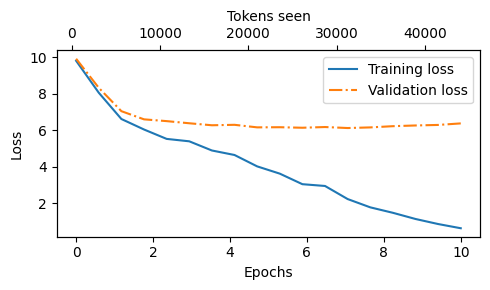

In [29]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
   fig, ax1 = plt.subplots(figsize=(5, 3))
   ax1.plot(epochs_seen, train_losses, label="Training loss")
   ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
   ax1.set_xlabel("Epochs")
   ax1.set_ylabel("Loss")
   ax1.legend(loc="upper right")
   ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
   ax2 = ax1.twiny()
   ax2.plot(tokens_seen, train_losses, alpha=0)
   ax2.set_xlabel("Tokens seen")
   fig.tight_layout()
   plt.show()
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [30]:
model.eval();

In [31]:
tokenizer = tiktoken.get_encoding("gpt2")
encoded = text_to_token_ids("Every effort moves you", tokenizer).to(device) # Move encoded to the correct device
token_ids = generate_text_simple(model=model,idx=encoded,max_new_tokens=25,context_size=GPT_CONFIG_124M["context_length"])
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [32]:
vocab = {
"closer": 0,
"every": 1,
"effort": 2,
"forward": 3,
"inches": 4,
"moves": 5,
"pizza": 6,
"toward": 7,
"you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

In [33]:
next_token_logits = torch.tensor([4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])

In [34]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [35]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [36]:
sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
sampled_ids = torch.bincount(torch.tensor(sample))
sampled_ids

tensor([ 73,   0,   0, 581,   2,   0,   0, 344])

In [37]:
def print_sampled_tokens(probas):
   torch.manual_seed(123)
   sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
   sampled_ids = torch.bincount(torch.tensor(sample))
   for i, freq in enumerate(sampled_ids):
      print(f"{freq} x {inverse_vocab[i]}")
print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


In [38]:
def softmax_with_temperature(logits, temperature):
   scaled_logits = logits / temperature
   return torch.softmax(scaled_logits, dim=0)

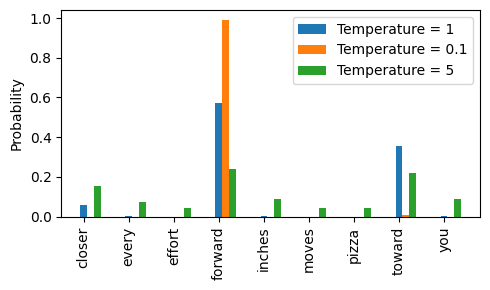

In [39]:
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
   rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

In [40]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [41]:
new_logits = torch.where(condition=next_token_logits < top_logits[-1], input=torch.tensor(float('-inf')), other=next_token_logits)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [42]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [43]:
def generate(model, idx, max_new_tokens, context_size,temperature=0.0, top_k=None, eos_id=None):
   for _ in range(max_new_tokens):
      idx_cond = idx[:, -context_size:].to(idx.device) # Ensure idx_cond is on the correct device
      with torch.no_grad():
         logits = model(idx_cond)
      logits = logits[:, -1, :]
      if top_k is not None:
         top_logits, _ = torch.topk(logits, top_k)
         min_val = top_logits[:, -1]
         logits = torch.where(logits < min_val,torch.tensor(float('-inf')).to(logits.device),logits) # Ensure the comparison tensor is on the correct device
      if temperature > 0.0:
         logits = logits / temperature
         probs = torch.softmax(logits, dim=-1)
         idx_next = torch.multinomial(probs, num_samples=1)
      else:
         idx_next = torch.argmax(logits, dim=-1, keepdim=True)
      if idx_next == eos_id:
         break
      idx = torch.cat((idx, idx_next), dim=1)
   return idx


In [44]:
torch.manual_seed(123)
token_ids = generate(model=model, idx=text_to_token_ids("Every effort moves you", tokenizer).to(device), max_new_tokens=15,
                     context_size=GPT_CONFIG_124M["context_length"], top_k=25, temperature=1.4)

In [45]:
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as his pictures, and rather a cheap genius-- that stuff Mrs. Poor


In [46]:
torch.save(model.state_dict(), "model.pth")

In [47]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval();

In [48]:
torch.save({"model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict(),}, "model_and_optimizer.pth")

In [49]:
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

In [50]:
pip install tensorflow>=2.15.0 tqdm>=4.66

In [51]:
import urllib.request
url = (
"https://raw.githubusercontent.com/rasbt/"
"LLMs-from-scratch/main/ch05/"
"01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7de5597a63c0>)

In [52]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 114kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 2.42MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 151kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [00:37<00:00, 13.2MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 6.85MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 1.50MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.52MiB/s]


In [53]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [55]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [56]:
model_configs = {
"gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
"gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
"gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [57]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

In [58]:
NEW_CONFIG.update({"context_length": 1024})

In [59]:
NEW_CONFIG.update({"qkv_bias": True})

In [61]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [62]:
def assign(left, right):
   if left.shape != right.shape:
      raise ValueError(f"Shape mismatch. Left: {left.shape}, " "Right: {right.shape}")
   return torch.nn.Parameter(torch.tensor(right))

In [63]:
import numpy as np
def load_weights_into_gpt(gpt, params):
   gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
   gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
   for b in range(len(params["blocks"])):
      q_w, k_w, v_w = np.split((params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
      gpt.trf_blocks[b].att.W_query.weight = assign(gpt.trf_blocks[b].att.W_query.weight, q_w.T)
      gpt.trf_blocks[b].att.W_key.weight = assign(gpt.trf_blocks[b].att.W_key.weight, k_w.T)
      gpt.trf_blocks[b].att.W_value.weight = assign(gpt.trf_blocks[b].att.W_value.weight, v_w.T)
      q_b, k_b, v_b = np.split((params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
      gpt.trf_blocks[b].att.W_query.bias = assign(gpt.trf_blocks[b].att.W_query.bias, q_b)
      gpt.trf_blocks[b].att.W_key.bias = assign(gpt.trf_blocks[b].att.W_key.bias, k_b)
      gpt.trf_blocks[b].att.W_value.bias = assign(gpt.trf_blocks[b].att.W_value.bias, v_b)
      gpt.trf_blocks[b].att.out_proj.weight = assign(gpt.trf_blocks[b].att.out_proj.weight, params["blocks"][b]["attn"]["c_proj"]["w"].T)
      gpt.trf_blocks[b].att.out_proj.bias = assign(gpt.trf_blocks[b].att.out_proj.bias, params["blocks"][b]["attn"]["c_proj"]["b"])
      gpt.trf_blocks[b].ff.layers[0].weight = assign(gpt.trf_blocks[b].ff.layers[0].weight, params["blocks"][b]["mlp"]["c_fc"]["w"].T)
      gpt.trf_blocks[b].ff.layers[0].bias = assign(gpt.trf_blocks[b].ff.layers[0].bias, params["blocks"][b]["mlp"]["c_fc"]["b"])
      gpt.trf_blocks[b].ff.layers[2].weight = assign(gpt.trf_blocks[b].ff.layers[2].weight, params["blocks"][b]["mlp"]["c_proj"]["w"].T)
      gpt.trf_blocks[b].ff.layers[2].bias = assign(gpt.trf_blocks[b].ff.layers[2].bias, params["blocks"][b]["mlp"]["c_proj"]["b"])
      gpt.trf_blocks[b].norm1.scale = assign(gpt.trf_blocks[b].norm1.scale, params["blocks"][b]["ln_1"]["g"])
      gpt.trf_blocks[b].norm1.shift = assign(gpt.trf_blocks[b].norm1.shift, params["blocks"][b]["ln_1"]["b"])
      gpt.trf_blocks[b].norm2.scale = assign(gpt.trf_blocks[b].norm2.scale, params["blocks"][b]["ln_2"]["g"])
      gpt.trf_blocks[b].norm2.shift = assign(gpt.trf_blocks[b].norm2.shift, params["blocks"][b]["ln_2"]["b"])
   gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
   gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
   gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [64]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [65]:
torch.manual_seed(123)
token_ids = generate(model=gpt, idx=text_to_token_ids("Every effort moves you", tokenizer).to(device), max_new_tokens=25,
                     context_size=NEW_CONFIG["context_length"], top_k=50, temperature=1.5)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as far as the hand can go until the end of your turn unless something happens

This would remove you from a battle


In [67]:
train_loss = calc_loss_loader(train_loader, gpt, device)
val_loss = calc_loss_loader(val_loader, gpt, device)

In [68]:
train_loss

3.7547631528642444

In [69]:
val_loss

3.559633255004883